In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

Tabluar implementation of;

- UCB Hoeffding exploration
- UCB Brnstein exploration

In [2]:
n_actions = 16
n_states = 64
gamma = 0.999
H = 100  # number of time steps in a episode
K = 1000  # number of episodes

In [3]:
# utils
def onehot(idx, N): # hacky. i know...
    return np.eye(N)[idx]

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def sample(x, logits):
    # or could use gumbel trick
    p = softmax(logits)
    return np.random.choice(x, p=p)

In [4]:
class Env():
    def __init__(self, n_states, n_actions):
        """
        Args:
            n_states (int): the number of states
            n_actions (int): the number of action
        """
        self.S = np.arange(n_states)
        self.A = np.arange(n_actions)

        # each action move from state(i) to state(j) with probability close to 1.
        # BUG nope. softmax doesnt do this. will need to set to -infty
        self.P = 20*np.stack([np.random.permutation(np.eye(n_states, dtype=np.float32)) for _ in range(n_actions-1)] + [np.eye(n_states, dtype=np.float32)],axis=0)  
        # NOTE this graph might be disconnected. but is unlikely!?

        # reward is only a fn of the current state - shape = [n_states]
        # also. is sparse.
        self.R = onehot(np.random.randint(0, n_states), n_states)

    def step(self, state, action):
        """
        A tabular, probabilistic step function. 

        Args:
            state (int): An element of S. The current state
            state (int): An element of A. The action to be taken

        Returns:
            new_state (int): An element of S.
        """
        # step by selecting relevant transition matrix and applying
        logits = np.matmul(self.P[action, ...], onehot(state, n_states))
        # convert to a distribution and sample
        new_s = np.random.choice(self.S, p=softmax(logits))
        return new_s, self.R[new_s]
    
    def rnd_policy(self, s, *args):
        return np.random.choice(self.A)
    
    def reset(self):
        return np.random.choice(self.S)

    def new_task(self):
        self.R = onehot(np.random.randint(0, n_states), n_states)

In [5]:
env = Env(n_states, n_actions)
env.step(0, env.rnd_policy(env.reset()))

(60, 0.0)

In [6]:
class TabularSARSA():
    def __init__(self, n_states, n_actions):
        self.gamma = 0.999
        self.lr = 0.1

        self.qs = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = sample(np.arange(n_actions), self.qs[s, ...])
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!
        self.qs -= 1e-4 * self.qs  # entropy regularisation

In [7]:
class UCB():
    def __init__(self, action_space):
        self.action_space = action_space
        self.n_actions = len(self.action_space)

        self.lr = 0.1
        self.reset()

    def choose_action(self, s):
        s = 0
        # Hoeffding
        util = self.vals + 1/np.sqrt(self.counts+1)  # utility = exploit + explore
        p = softmax(util)
        a = np.random.choice(self.action_space, p=p)

        self.counts[a] += 1

        return a
    
    def __call__(self, s, r, done, *args):
        a = self.choose_action(s)
        
        if np.sum(self.counts)>1 and not done:
            self.train_step(self.old_a, r)
                
        # loop past actions so we can use them for training
        self.old_a = a
        
        if done:
            self.reset()
                
        return a
    
    def train_step(self, old_a, r):
        delta =  r - self.vals[old_a]  # target - estimate
        self.vals[old_a] += self.lr * delta  # incremental update. exp avg/GD!
        
    def reset(self):
        self.vals = np.zeros([self.n_actions])
        self.counts = np.zeros([self.n_actions])
    
        self.old_a = None
        self.old_r = None

class TabularUCBHoeffding():
    def __init__(self, n_states, n_options, n_actions):
        self.n_actions = n_actions
        self.n_options = n_options
        self.n_states = n_states
        self.gamma = 0.999
        self.lr = 0.1
        
        self.c = 


        self.counts = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = sample(np.arange(self.n_actions), self.qs[s, self.w, :])
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, r+b, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        ### Qs
        # the option critic value estimate
        omega_s_tp1 = self.q_omega(s)
        next_state_value = ((1-self.term_probs[s, self.w]) * omega_s_tp1[self.w]
                           + self.term_probs[s, self.w] * np.max(omega_s_tp1))
        # bootstrap off next step. TD!
        target = old_r + self.gamma*next_state_value
        # estimate grad of MSBE
        delta =  target - self.qs[old_s, self.w, old_a]
        # incremental update. exp avg/GD!
        self.qs[old_s, self.w, old_a] += self.lr * delta  
        
        ### termination props
        # value_actual_w - value_best_w
        self.term_probs -= self.lr * (omega_s_tp1[self.w] - next_state_value)
        self.term_probs /= np.sum(self.term_probs, axis=0)
        # need to normalise these!?!?
        
        ### policy
        # none...
        pass

In [8]:
class TabularFuN():
    # Tabular feudal network
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        
        self.gamma = 0.999
        self.lr = 0.1

        # current_state x goal _state
        self.manager_qs = np.zeros([n_states, n_states])
        # current_state x goal_state x n_actions
        self.worker_qs = np.zeros([n_states, n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_g = None
        
        self.R = 0
        
        self.counter = 0
        
        self.subgoal_steps = 3
    
    def __call__(self, s, r):
        # sample goal (do this less often).
        if self.counter % self.subgoal_steps == 0:
            g = sample(np.arange(self.n_states), self.manager_qs[s, :])  
        else: 
            g = self.old_g
            
        # pick action
        a = sample(np.arange(self.n_actions), self.worker_qs[s, g, :])
        
        self.R += r
        if self.old_s is not None:
            if self.counter % self.subgoal_steps == 0:
                # should be cumulating r over the subgoal steps
                self.train_manager_step(self.old_s, self.old_a, self.old_g, self.R, g, s, a)
                self.R = 0
            
            # reward worker for ability to achieve goals
            # NOTE this is important! in this case I am using a sparse metric for the intrinsic reward!
            # but if using a state representation then we could use d(s_{t+1}, s_g)
            # need knowledge of the model to do this
            worker_r = np.equal(s, self.old_g).astype(np.int32) + r
            # this + r seems important/cheating...
            self.train_worker_step(self.old_s, self.old_a, self.old_g, worker_r, g, s, a)

        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
        self.old_g = copy.deepcopy(g)
        
        self.counter += 1
        
        return a
    
    def train_manager_step(self, old_s, old_a, old_g, r, g, s, a):
        target = r + self.gamma*self.manager_qs[s, g]  # bootstrap off next step. TD!
        delta =  target - self.manager_qs[old_s, old_g]
        self.manager_qs[old_s, old_g] += self.lr * delta  # incremental update. exp avg/GD!
    
    def train_worker_step(self, old_s, old_a, old_g, r, g, s, a):    
        target = r + self.gamma*self.worker_qs[s, g, a]  # bootstrap off next step. TD!
        delta =  target - self.worker_qs[old_s, old_g, old_a]
        self.worker_qs[old_s, old_g, old_a] += self.lr * delta  # incremental update. exp avg/GD!

In [9]:
def play_episode(env, player, len_episode):
    # reset
    s = env.reset()
    total_r = 0
    r = 0
    w = np.random.randint(8)
    
    # play an episode
    for _ in range(len_episode):
        a = player(s, r)
        s, r = env.step(s, a)
        total_r += r
        
    return total_r/len_episode

def plot(x, label):
    x = np.array(x)
    if len(x.shape) == 2:
        n = len(x[0])
        idx = range(n)
        mean = np.mean(x, axis=0)
        stddev = np.sqrt(np.var(x,axis=0)) 

        # smooth the signals
        n_kernel = 20
        kernel = [1]*n_kernel
        mean = np.convolve(mean, kernel)[:n]/n_kernel
        stddev = np.convolve(stddev, kernel)[:n]/n_kernel

        # plot
        plt.plot(idx, mean, label=label)
        plt.fill_between(idx, mean-stddev, mean+stddev,  alpha=0.3)
        
    else:
        n = len(x)
        idx = range(n)
        n_kernel = 20
        kernel = [1]*n_kernel
        x = np.convolve(x, kernel)[:n]/n_kernel
        plt.plot(idx, x, label=label)

In [10]:
n_states=64
n_actions=3
n_options=n_actions
env = Env(n_states, n_actions)
n_steps = 200
n_episodes = 2000

In [12]:
q_player = TabularSARSA(n_states, n_actions)
q_rs = [play_episode(env, q_player, n_steps) for _ in range(n_episodes)]

fun_player = TabularFuN(n_states, n_actions)
fun_rs = [play_episode(env, fun_player, n_steps) for _ in range(n_episodes)]

opc_player = TabularOpC(n_states, n_options, n_actions)
opc_rs = [play_episode(env, opc_player, n_steps) for _ in range(n_episodes)]

rnd_player = lambda s, r: np.random.randint(n_actions)
rnd_rs = [play_episode(env, rnd_player, n_steps) for _ in range(n_episodes)]

/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


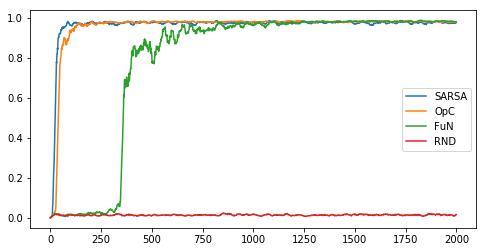

In [13]:
plt.figure(figsize=(8, 4))
plot(q_rs, 'SARSA')
plot(opc_rs, 'OpC')
plot(fun_rs, 'FuN')
plot(rnd_rs, 'RND')
plt.legend()

In [14]:
# reproduce Figure 2. from "The option critic architecture" (Bacon, Harb, Precup 2017)
# change the task half way and see how quickly each learner recovers

n_episodes = 3000
n_trials = 20

Q_rs = []
OpC_rs = []
FuN_rs = []
for j in range(n_trials):
    env = Env(n_states, n_actions)
    
    q_player = TabularSARSA(n_states, n_actions)
    q_rs = []
    
    opc_player = TabularOpC(n_states, n_options, n_actions)
    opc_rs = []
    
    fun_player = TabularFuN(n_states, n_actions)
    fun_rs = []
    
    for i in range(n_episodes):
        # change tasks. (randomly move the location of the reward)
        if i == n_episodes//2:
            env.new_task()
        
        q_r = play_episode(env, q_player, n_steps)
        q_rs.append(q_r)
        
        opc_r = play_episode(env, opc_player, n_steps)
        opc_rs.append(opc_r)
        
        fun_r = play_episode(env, fun_player, n_steps)
        fun_rs.append(fun_r)
        
    Q_rs.append(np.array(q_rs))
    OpC_rs.append(np.array(opc_rs))
    FuN_rs.append(np.array(fun_rs))
    print('\r{}'.format(j), end='', flush=True)

Q_rs = np.vstack(Q_rs)
OpC_rs = np.vstack(OpC_rs)
FuN_rs = np.vstack(FuN_rs)

4

/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


19

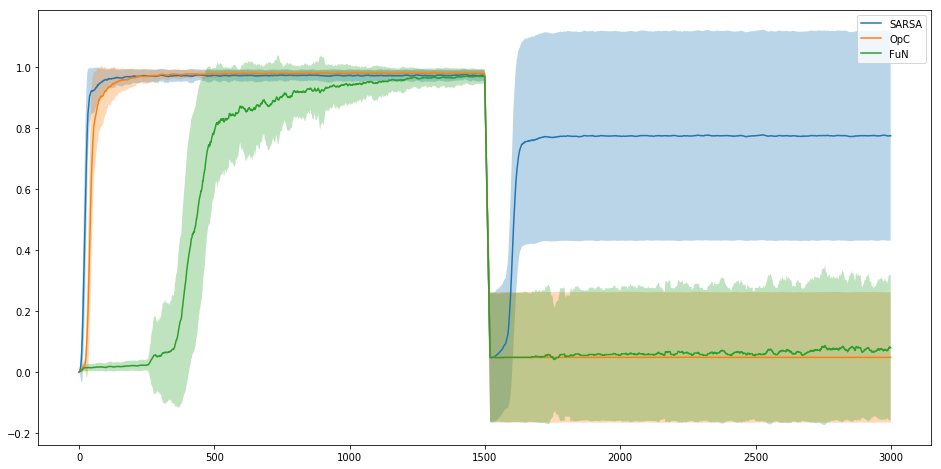

In [15]:
plt.figure(figsize=(16, 8))
plot(Q_rs, label='SARSA')
plot(OpC_rs, label='OpC')
plot(FuN_rs, label='FuN')
plt.legend()

Should we expect that HRL/options will generalise more easily to other rewards/tasks!?
They might transfer some of the options. BUT, the options might be totally wrong!? I am not convinced this should work, but it seems to help (a little...)?!?